# Predicción de precipitaciones mensuales en Medellín mediante técnicas de series temporales de Deep Learning

## Introducción<a class="anchor" id="1"></a>

La predicción meteorológica es un campo popular para la aplicación de modelos de series temporales. Hay varios enfoques utilizados para resolver problemas de series temporales, incluidos los métodos estadísticos clásicos, como el grupo de modelos ARIMA, los modelos de aprendizaje automático y los modelos de aprendizaje profundo. La implementación actual del modelo de series temporales de ArcGIS learn utiliza redes neuronales convolucionales de última generación especialmente curadas para conjuntos de datos de series temporales. Entre ellas se incluyen InceptionTime, ResCNN, Resnet y FCN. Lo que hace que el modelado de series temporales sea único es que, en la metodología clásica de ARIMA, múltiples hiperparámetros requieren un ajuste fino antes de ajustar el modelo, mientras que con la técnica actual de aprendizaje profundo, la mayoría de los parámetros son aprendidos por el propio modelo a partir de los datos.

## Imports <a class="anchor" id="2"></a>

In [174]:
from arcgis.learn import TimeSeriesModel, prepare_tabulardata
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime as dt
from IPython.display import Image, HTML
from sklearn.model_selection import train_test_split

In [175]:
file_ideam = r'C:\Users\JHERNANDEZ\OneDrive - Esri NOSA\Consultoría\Alcaldia_Medellin\Time_Series\Preprocessing_Data\27011110.xlsx'
cali_rainfall_df1 = pd.read_excel(file_ideam)
cali_rainfall_df1_sorted = cali_rainfall_df1.sort_values(by = 'Fecha')
cali_rainfall_df1_sorted.head()

,Fecha,Valor,Nivel de Aprobación
0,1992-01-01 00:00,22.0,Definitivo
1,1992-02-01 00:00,75.6,Definitivo
2,1992-03-01 00:00,51.0,Definitivo
3,1992-04-01 00:00,185.0,Definitivo
4,1992-05-01 00:00,204.0,Definitivo


In [176]:
cali_rainfall_df1_sorted.shape

(397, 3)

In [177]:
cali_rainfall_df1_sorted.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397 entries, 0 to 396
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Fecha                397 non-null    object 
 1   Valor                397 non-null    float64
 2   Nivel de Aprobación  397 non-null    object 
dtypes: float64(1), object(2)
memory usage: 9.4+ KB


## Preparación de series de tiempo<a class="anchor" id="5"></a>   
La preparación de los datos para la modelización de series temporales consta de los tres pasos siguientes:

###  Secuenciación de datos de series temporales<a class="anchor" id="7"></a>

El primer paso consiste en establecer la secuencia de los datos de las series temporales, lo que se hace creando un nuevo índice que utiliza el modelo para procesar los datos secuenciales. 

In [178]:
# The first step consist of reindexing the timeseries data into a sequential series  
cali_rainfall_reindexed = cali_rainfall_df1_sorted.reset_index()
cali_rainfall_reindexed = cali_rainfall_reindexed.drop("index", axis=1)
cali_rainfall_reindexed.head()

,Fecha,Valor,Nivel de Aprobación
0,1992-01-01 00:00,22.0,Definitivo
1,1992-02-01 00:00,75.6,Definitivo
2,1992-03-01 00:00,51.0,Definitivo
3,1992-04-01 00:00,185.0,Definitivo
4,1992-05-01 00:00,204.0,Definitivo


###  Datatypes of timeseries variable<a class="anchor" id="8"></a> 
The next step validates the data types of the variables.

In [179]:
# check the data types of the variables
cali_rainfall_reindexed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397 entries, 0 to 396
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Fecha                397 non-null    object 
 1   Valor                397 non-null    float64
 2   Nivel de Aprobación  397 non-null    object 
dtypes: float64(1), object(2)
memory usage: 9.4+ KB


###  Comprobación de la autocorrelación de una variable de serie temporal<a class="anchor" id="10"></a>
El paso más importante en este proceso es determinar si la secuencia de series temporales está autocorrelacionada. Para asegurarnos de que nuestros datos de series temporales pueden modelizarse bien, hay que estimar la fuerza de correlación de la variable con sus datos pasados.

In [180]:
from pandas.plotting import autocorrelation_plot

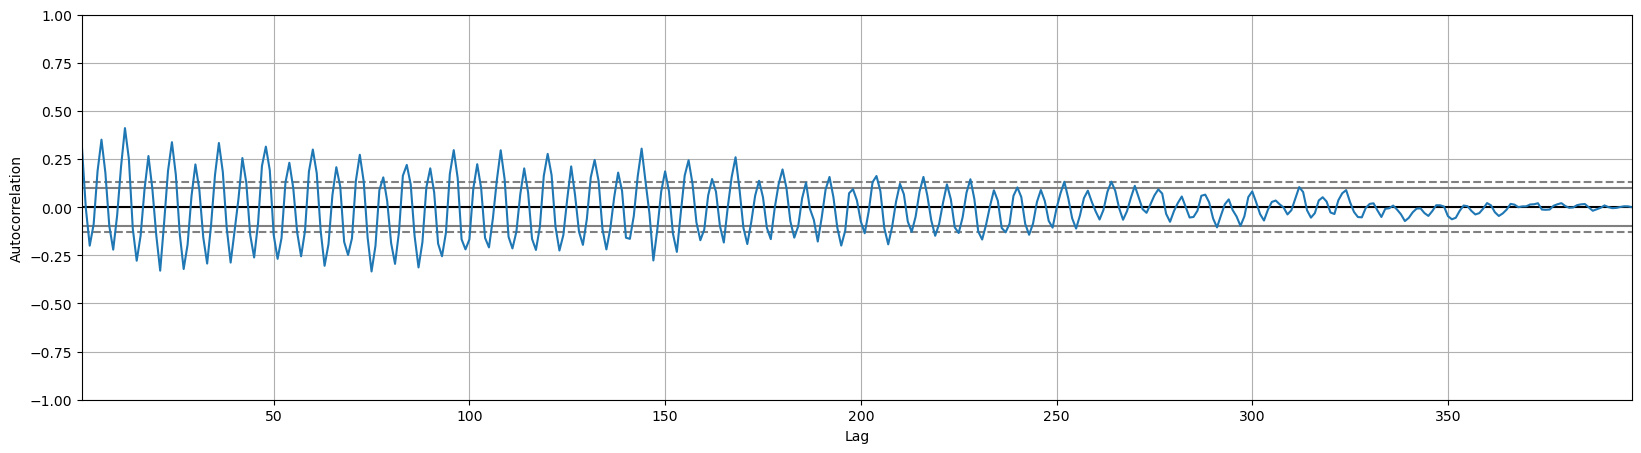

In [181]:
plt.figure(figsize = (20, 5))
autocorrelation_plot(cali_rainfall_reindexed["Valor"])
plt.show()

El gráfico anterior nos muestra que existe una correlación significativa de los datos con sus términos retardados inmediatos, y que disminuye gradualmente con el tiempo a medida que aumenta el retardo. 

### Dividir el conjunto de datos de series temporales entre entrenamiento y prueba<a class="anchor" id="6"></a>

In [182]:
# Dividir datos de series temporales conservando la secuencia original manteniendo shuffle=False, y tamaño de prueba de 12 meses para la validación. 
test_size = 6
train, test = train_test_split(cali_rainfall_reindexed, test_size = test_size, shuffle = False)
train 

,Fecha,Valor,Nivel de Aprobación
0,1992-01-01 00:00,22.0,Definitivo
1,1992-02-01 00:00,75.6,Definitivo
2,1992-03-01 00:00,51.0,Definitivo
3,1992-04-01 00:00,185.0,Definitivo
4,1992-05-01 00:00,204.0,Definitivo
...,...,...,...
386,2024-03-01 00:00,22.0,Preliminar
387,2024-04-01 00:00,268.0,Preliminar
388,2024-05-01 00:00,328.0,Preliminar
389,2024-06-01 00:00,364.0,Preliminar


## Construcción de modelos <a class="anchor" id="9"></a>

Una vez que el conjunto de datos se divide en datos de entrenamiento y datos de prueba, los datos de entrenamiento están listos para ser utilizados en el modelado.

### Preprocesamiento de datos <a class="anchor" id="11"></a>

En este ejemplo, los datos utilizados son una serie temporal univariante de precipitaciones mensuales totales en milímetros. Esta única variable se utilizará para predecir los 12 meses de precipitaciones de los meses posteriores a la última fecha de los datos de entrenamiento, o dicho de otro modo, se utilizará una única variable para predecir los valores futuros de esa misma variable. En el caso de un modelo multivariante de series temporales, habría una lista de múltiples variables explicativas.

Una vez identificadas las variables, el preprocesamiento de los datos se realiza mediante el método `prepare_tabulardata` del módulo `arcgis.learn` de la API de ArcGIS para Python. Esta función tomará como entrada un marco de datos no espacial, una capa de características o un marco de datos espacial que contenga el conjunto de datos, y devolverá un objeto TabularDataObject que puede introducirse en el modelo. 

Los principales parámetros de entrada necesarios para la herramienta son:

- <span>input_features</span> : non spatial dataframe, feature layer, or spatial dataframe containing the primary dataset and the explanatory variables, if there are any
- <span>variable_predict</span> : field name containing the y-variable to be forecasted from the input feature layer/dataframe
- <span>explanatory_variables</span> : list of the field names as 2-sized tuples containing the explanatory variables as mentioned above. Since there are none in this example, it is not required here 
- <span>index_field</span> : field name containing the timestamp

En este punto, se podrían utilizar preprocesadores para escalar los datos utilizando un escalador de la siguiente manera, en función de la distribución de los datos.

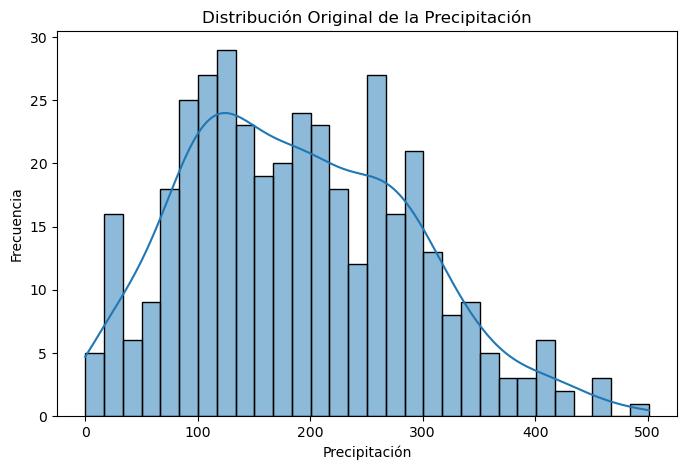

In [183]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
plt.figure(figsize=(8,5))
sns.histplot(train['Valor'], kde=True, bins=30)
plt.title("Distribución Original de la Precipitación")
plt.xlabel("Precipitación")
plt.ylabel("Frecuencia")
plt.show()

Shapiro-Wilk Test: Estadístico = 0.9811285734176636, p-valor = 5.4825239203637466e-05


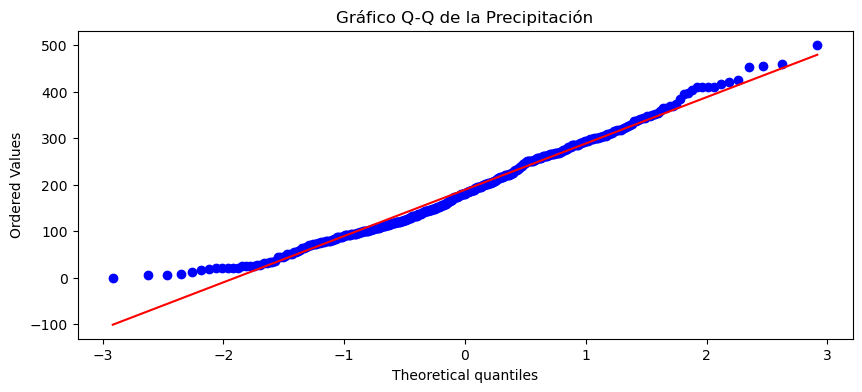

In [184]:
shapiro_test = stats.shapiro(train['Valor'])
print(f"Shapiro-Wilk Test: Estadístico = {shapiro_test.statistic}, p-valor = {shapiro_test.pvalue}")
plt.figure(figsize=(10, 4))
stats.probplot(train['Valor'], dist="norm", plot=plt)
plt.title("Gráfico Q-Q de la Precipitación")
plt.show()

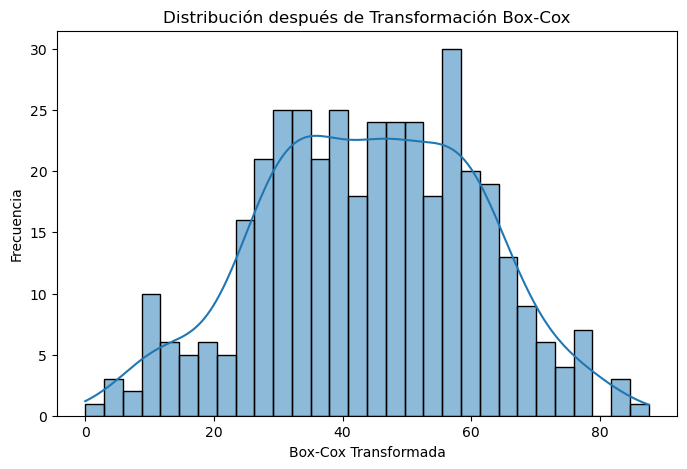

Lambda óptima de Box-Cox: 0.6536981263032552


In [185]:
train['boxcox_precip'], lambda_boxcox = stats.boxcox(train['Valor'] + 1)
plt.figure(figsize=(8,5))
sns.histplot(train['boxcox_precip'], kde=True, bins=30)
plt.title("Distribución después de Transformación Box-Cox")
plt.xlabel("Box-Cox Transformada")
plt.ylabel("Frecuencia")
plt.show()
print(f"Lambda óptima de Box-Cox: {lambda_boxcox}")

Shapiro-Wilk Test: Estadístico = 0.9935625791549683, p-valor = 0.09480620175600052


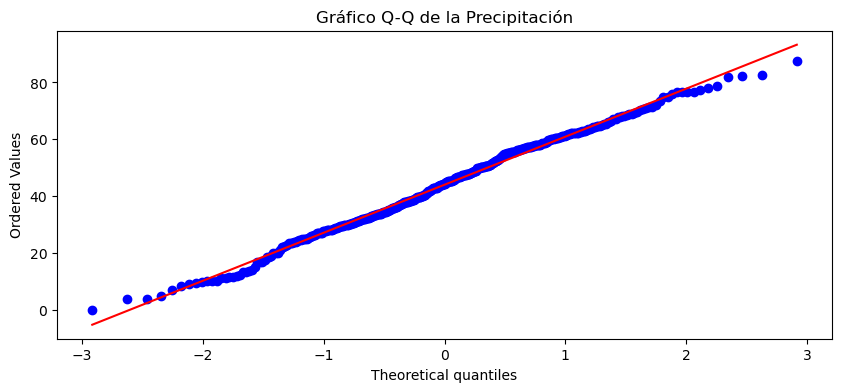

In [186]:
shapiro_test = stats.shapiro(train['boxcox_precip'])
print(f"Shapiro-Wilk Test: Estadístico = {shapiro_test.statistic}, p-valor = {shapiro_test.pvalue}")
plt.figure(figsize=(10, 4))
stats.probplot(train['boxcox_precip'], dist="norm", plot=plt)
plt.title("Gráfico Q-Q de la Precipitación")
plt.show()

In [187]:
#from sklearn.preprocessing import MinMaxScaler
#preprocessors = [('boxcox_precip', MinMaxScaler())]
data = prepare_tabulardata(train, variable_predict = 'Valor', index_field = 'Fecha', seed=42)

Dataframe is not spatial, Rasters and distance layers will not work


Index field is not timestamp. Converting it to timestamp.


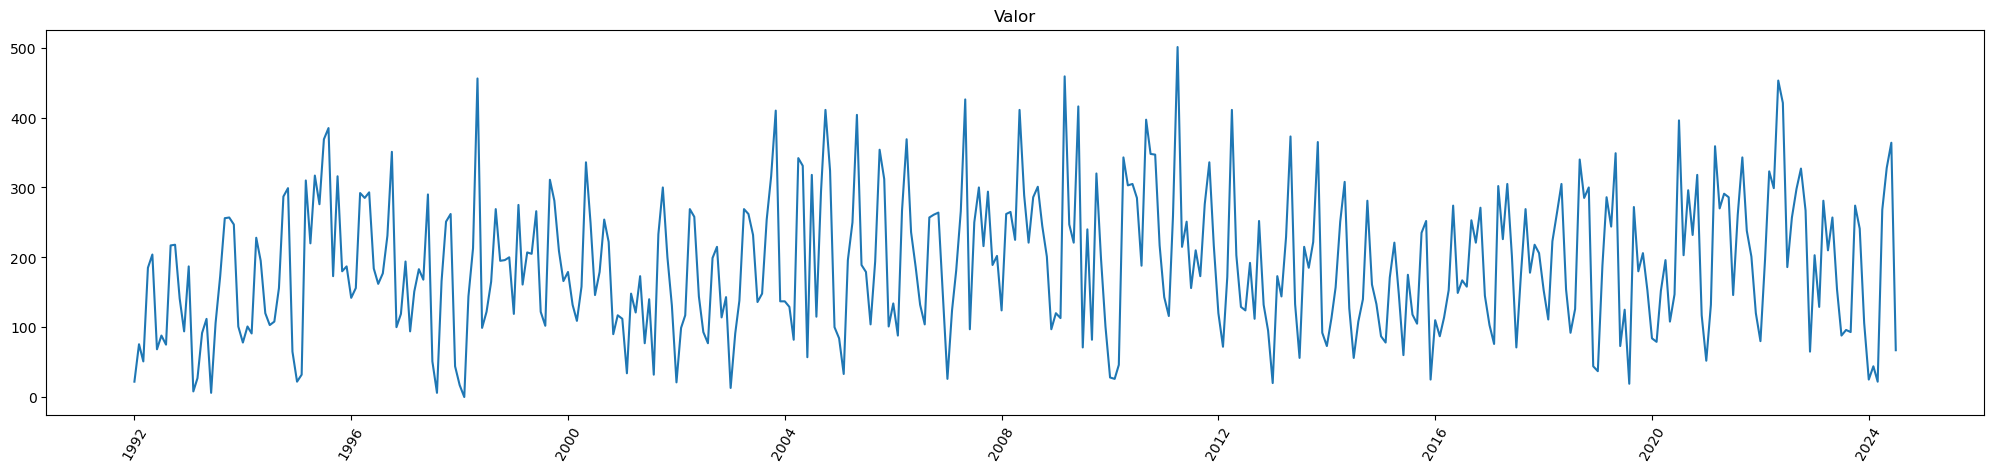

In [188]:
# Visualizar la serie de tiempo
data.show_batch(graph=True)

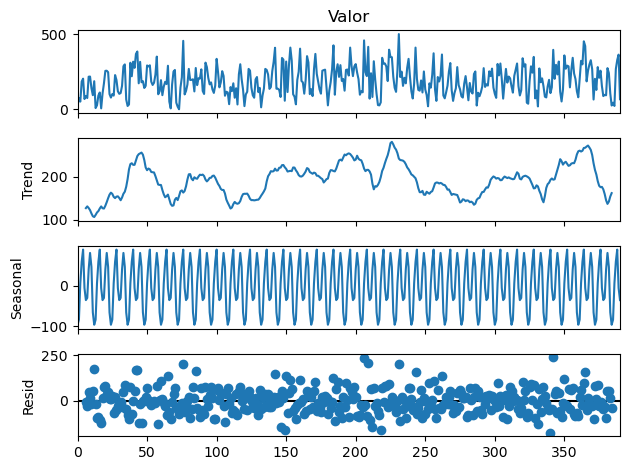

In [189]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposed = seasonal_decompose(train['Valor'], model = 'additive', period = 12)
decomposed.plot()
plt.show()

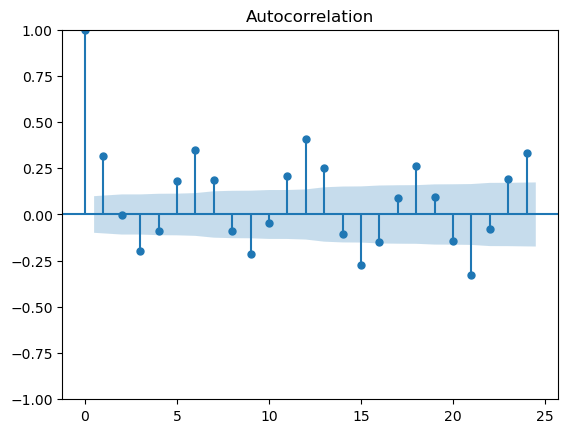

In [190]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(train['Valor'], lags=24)
plt.show()

In [191]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(train['Valor'])
print(f"ADF Statistic: {result[0]}")
print(f"P-value: {result[1]}")

if result[1] < 0.05:
    print("La serie es estacionaria")
else:
    print("La serie NO es estacionaria (puede tener estacionalidad o tendencia)")


ADF Statistic: -4.089242375890182
P-value: 0.0010089482372630336
La serie es estacionaria


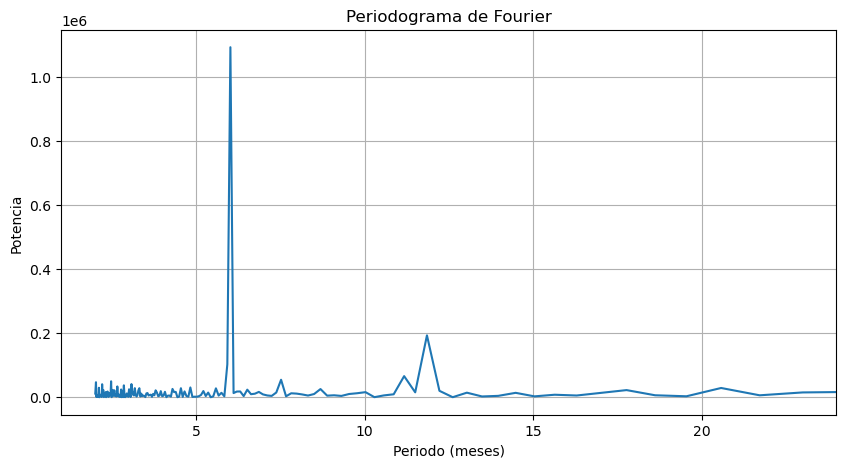

In [192]:
import numpy as np
from scipy.signal import periodogram
freqs, power = periodogram(train['Valor'], detrend='linear')
plt.figure(figsize=(10,5))
plt.plot(1/freqs, power)
plt.xlabel('Periodo (meses)')
plt.ylabel('Potencia')
plt.title('Periodograma de Fourier')
plt.xlim([1, 24])  # Rango de interés de 1 a 24 meses
plt.grid()
plt.show()

In [193]:
# En este caso, la longitud de la secuencia es 12, lo que también indica la estacionalidad de los datos.
seq_len = 12

Index field is not timestamp. Converting it to timestamp.


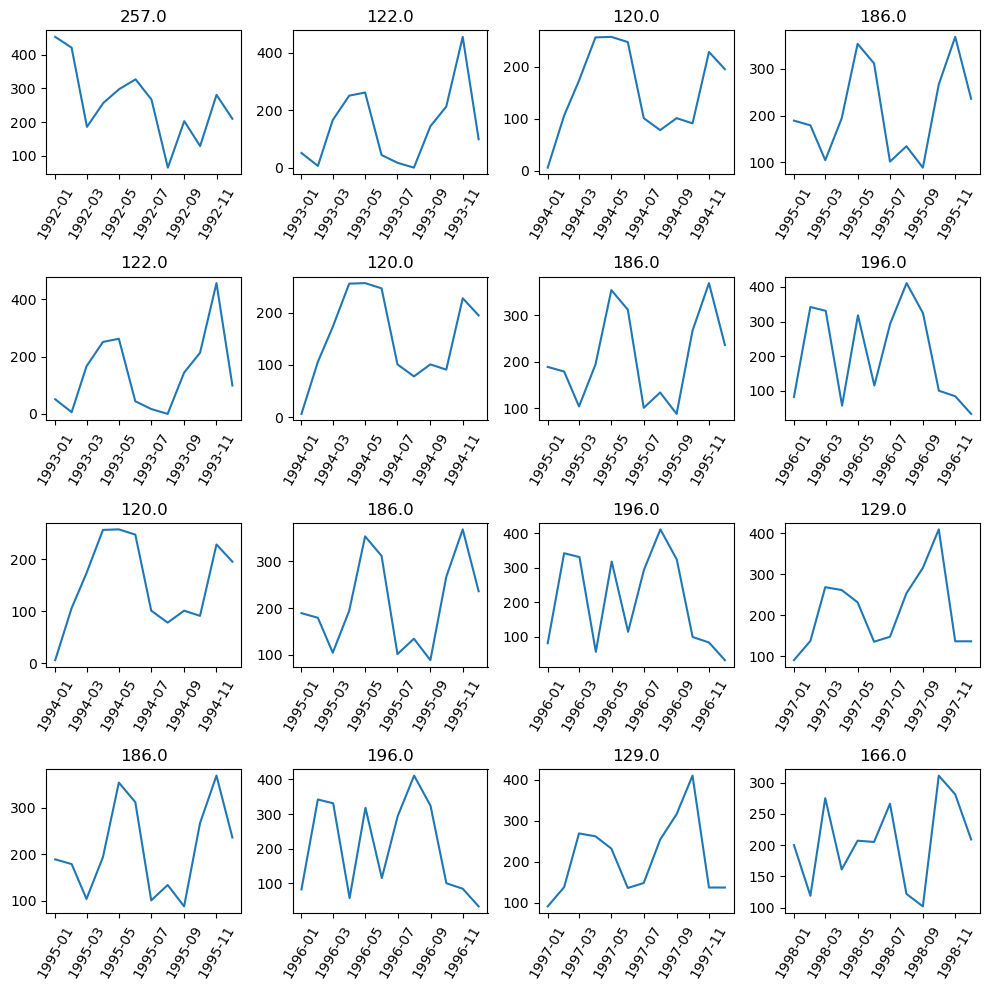

In [194]:
# Visualizar las series temporales en lotes, aquí se menciona la longitud de la secuencia que se trataría como la longitud del lote
data.show_batch(rows = 4, seq_len = seq_len)

### Inicialización del modelo <a class="anchor" id="12"></a>

Este es el paso más importante para ajustar un modelo de series temporales. Aquí, junto con los datos, se pasan como parámetros la columna vertebral para el entrenamiento del modelo y la longitud de la secuencia. De estos tres parámetros, la longitud de la secuencia debe seleccionarse con cuidado, ya que puede ser decisiva para el modelo. La longitud de la secuencia suele ser el ciclo de los datos, que en este caso es 12, ya que se trata de datos mensuales y el patrón se repite al cabo de 12 meses.

In [195]:
# En la inicialización del modelo, los datos y la red troncal se seleccionan del conjunto disponible de InceptionTime, ResCNN, Resnet, FCN, LSTM
ts_model = TimeSeriesModel(data, seq_len = seq_len, model_arch = 'ResCNN')

### Búsqueda de tasa de aprendizaje <a class="anchor" id="13"></a>

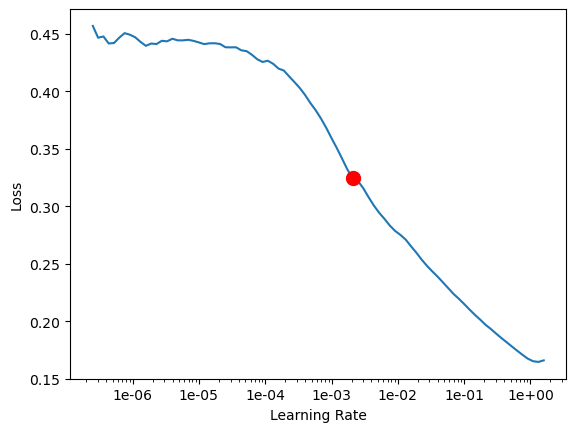

In [196]:
# Determinar la tasa de aprendizaje para entrenar el modelo
l_rate = ts_model.lr_find()

### Entrenamiento del modelo <a class="anchor" id="14"></a>

Por último, el modelo está listo para el entrenamiento. Para entrenar el modelo, se llama al método `model.fit` y se le proporciona el número de épocas para el entrenamiento y la tasa de aprendizaje estimada sugerida por `lr_find` en el paso anterior:

In [197]:
ts_model.fit(150, lr = l_rate, checkpoint=False)

epoch,train_loss,valid_loss,time
0,0.420914,0.274797,00:00
1,0.386221,0.342043,00:00
2,0.355544,0.378522,00:00
3,0.324846,0.357280,00:00
4,0.296910,0.385421,00:00
5,0.266507,0.338831,00:00
6,0.236546,0.264065,00:00
7,0.208156,0.188260,00:00
8,0.181400,0.120028,00:00
9,0.157344,0.062868,00:00


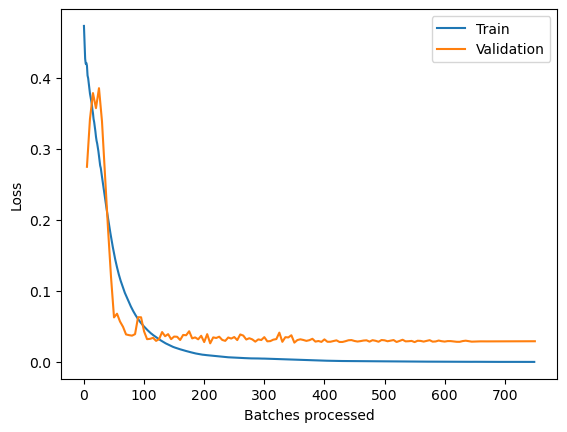

In [198]:
# Se trazan las pérdidas de entrenamiento frente a las pérdidas válidas para comprobar la calidad del modelo entrenado, y si el modelo necesita más entrenamiento. 
ts_model.plot_losses()

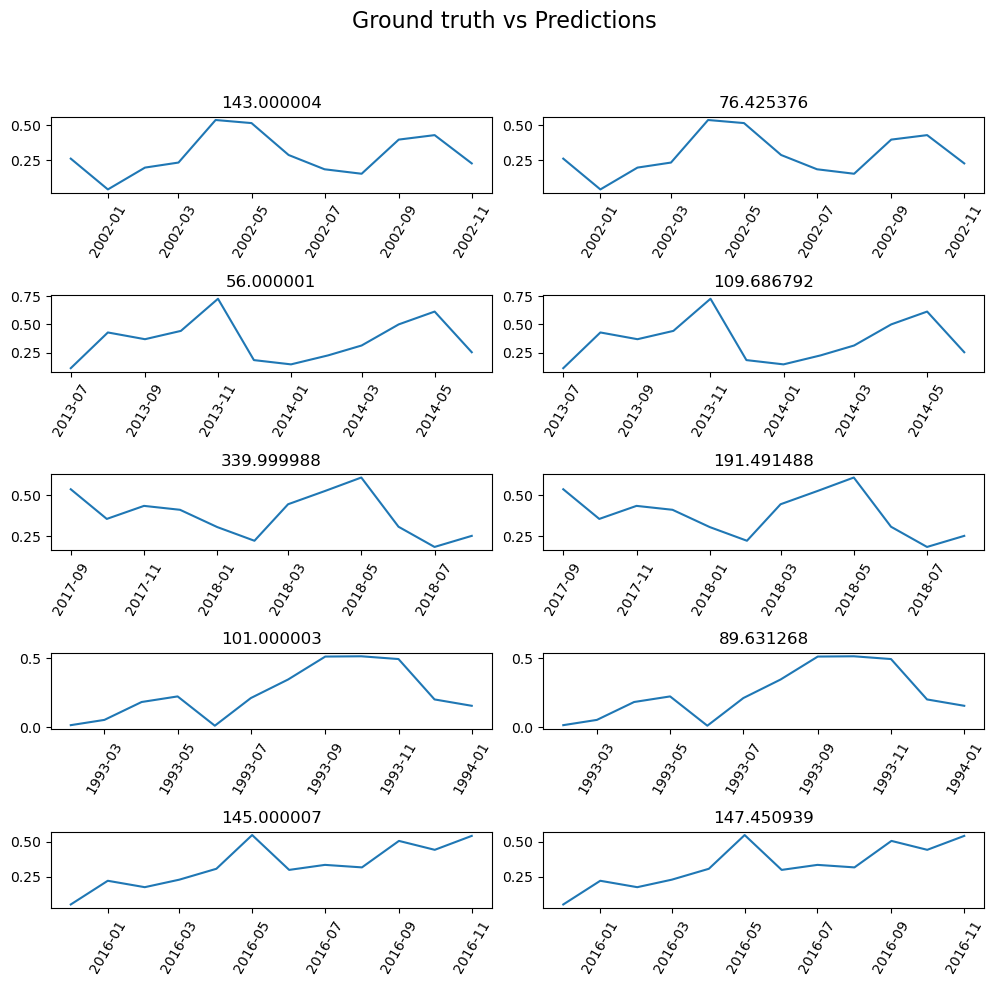

In [199]:
# the predicted values by the trained model is printed for the test set
ts_model.show_results(rows = 5)

The figures above display the training and the validation of the prediction attained by the model while training.

## Rainfall Forecast & Validation <a class="anchor" id="15"></a>

### Forecasting Using the trained Timeseries Model <a class="anchor" id="26"></a>
During forecasting, the model will use the same training dataset as input and will use the last sequence length number of terms from that dataset's tail to predict the rainfall for the number of months specified by the user.   

In [200]:
from datetime import datetime  

In [201]:
# checking the training dataset
train

,Fecha,Valor,Nivel de Aprobación,boxcox_precip
0,1992-01-01 00:00,22.0,Definitivo,10.349291
1,1992-02-01 00:00,75.6,Definitivo,24.552163
2,1992-03-01 00:00,51.0,Definitivo,18.717720
3,1992-04-01 00:00,185.0,Definitivo,45.050203
4,1992-05-01 00:00,204.0,Definitivo,48.107974
...,...,...,...,...
386,2024-03-01 00:00,22.0,Preliminar,10.349291
387,2024-04-01 00:00,268.0,Preliminar,57.755576
388,2024-05-01 00:00,328.0,Preliminar,66.095510
389,2024-06-01 00:00,364.0,Preliminar,70.845280


Forecasting requires the format of the date column to be in datetime. If the date column is not in the datetime format, it can be changed to datetime by using the `pd.to_datetime()` method. 

In [202]:
# checking if the datatype of the 'date' column is in datetime format
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 391 entries, 0 to 390
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Fecha                391 non-null    object 
 1   Valor                391 non-null    float64
 2   Nivel de Aprobación  391 non-null    object 
 3   boxcox_precip        391 non-null    float64
dtypes: float64(2), object(2)
memory usage: 23.4+ KB


In this example, the date column is already in the required datetime format.

Finally the predict function is used to forecast for a period of the 12 months subsequent to the last date in the training dataset. As such, this will be forecasting rainfall for the 12 months of 2019, starting from January of 2019.

In [203]:
# Here the forecast is returned as a dataframe, since it is non spatial data, mentioned in the 'prediction_type'     
sdf_forecasted = ts_model.predict(train, prediction_type='dataframe', number_of_predictions=test_size)

In [204]:
ts_model.save('TimeSeries_Model')

WindowsPath('c:/Users/JHERNANDEZ/OneDrive - Esri NOSA/Consultoría/Alcaldia_Medellin/Time_Series/models/TimeSeries_Model')

In [205]:
from scipy import stats
import numpy as np

def apply_boxcox(values, lambda_boxcox):
    """Aplica la transformación Box-Cox a los valores dados un lambda óptimo."""
    if lambda_boxcox == 0:
        return np.log(values)
    else:
        return (values ** lambda_boxcox - 1) / lambda_boxcox

test['boxcox_precip'] = apply_boxcox(test['Valor'] + 1, lambda_boxcox)

In [206]:
# Formatear el resultado en columnas reales frente a las previstas
sdf_forecasted = sdf_forecasted.tail(test_size)
sdf_forecasted = sdf_forecasted[['Fecha', 'Valor_results']]
sdf_forecasted['actual'] = test[test.columns[-3]].values
sdf_forecasted = sdf_forecasted.set_index(sdf_forecasted.columns[0])
sdf_forecasted.head()

,Valor_results,actual
Fecha,,
2024-08-01,89.353821,210.0
2024-09-01,174.296812,180.0
2024-10-02,226.615968,246.0
2024-11-02,218.728671,282.0
2024-12-03,249.713735,147.0


### Estimate model metrics for validation <a class="anchor" id="27"></a>
The accuracy of the forecasted values is measured by comparing the forecasted values against the actual values of the 12 months.

In [207]:
from sklearn.metrics import r2_score
import sklearn.metrics as metrics

In [208]:
r2_test = r2_score(sdf_forecasted['actual'], sdf_forecasted['Valor_results'])
print('R-Square: ', round(r2_test, 2))

R-Square:  -0.17


A considerably high r-squared value indicates a high similarity between the forecasted and the actual sales values.

In [209]:
mse_RF_train = metrics.mean_squared_error(sdf_forecasted['actual'], sdf_forecasted['Valor_results'])
print('RMSE: ', round(np.sqrt(mse_RF_train), 2))

mean_absolute_error_RF_train = metrics.mean_absolute_error(sdf_forecasted['actual'], sdf_forecasted['Valor_results'])
print('MAE: ', round(mean_absolute_error_RF_train, 2))

RMSE:  70.65
MAE:  55.41


The error terms of RMSE and MAE in the forecasting are 32.28mm and 25.55mm respectively, which are quite low.

## Result Visualization<a class="anchor" id="28"></a>

Finally, the actual and forecasted values are plotted to visualize their distribution over the 12 months period, with the blue lines indicating forecasted values and orange line showing the actual values.

In [210]:
sdf_forecasted["Fecha"] = sdf_forecasted.index.to_timestamp()

In [211]:
sdf_forecasted

,Valor_results,actual,Fecha
Fecha,,,
2024-08-01,89.353821,210.0,2024-08-01
2024-09-01,174.296812,180.0,2024-09-01
2024-10-02,226.615968,246.0,2024-10-02
2024-11-02,218.728671,282.0,2024-11-02
2024-12-03,249.713735,147.0,2024-12-03
2025-01-03,102.769583,82.0,2025-01-03


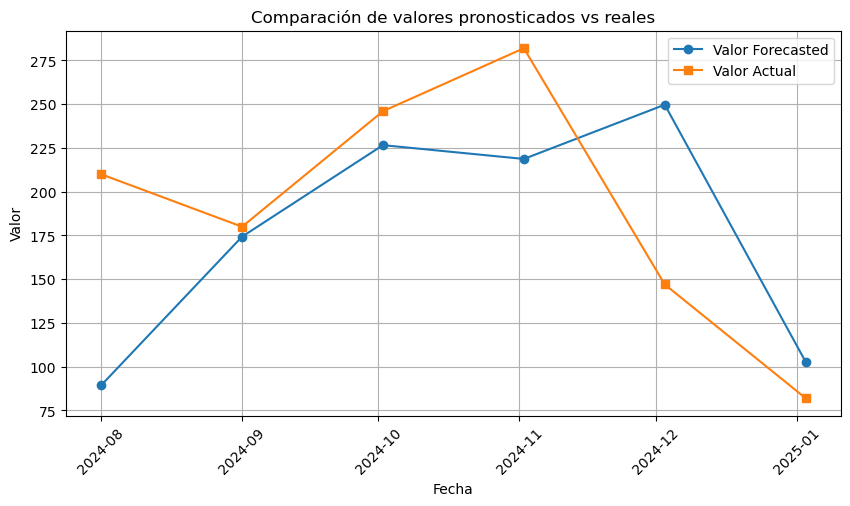

In [212]:
plt.figure(figsize=(10, 5))
plt.plot(sdf_forecasted["Fecha"], sdf_forecasted["Valor_results"], marker='o', linestyle='-', label="Valor Forecasted")
plt.plot(sdf_forecasted["Fecha"], sdf_forecasted["actual"], marker='s', linestyle='-', label="Valor Actual")
plt.xlabel("Fecha")
plt.ylabel("Valor")
plt.title("Comparación de valores pronosticados vs reales")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

### Summary of methods used <a class="anchor" id="24"></a>

| Method | Description | Examples |
| -| - |-|
| prepare_tabulardata| prepare data including imputation, normalization and train-test split  |prepare data ready for fitting a  Timeseries Model 
| model.lr_find()| find an optimal learning rate  | finalize a good learning rate for training the Timeseries model
| TimeSeriesModel() | Model Initialization by selecting the Timeseries Deeplearning algorithm to be used for fitting  | Selected Timsereis algorithm from Fastai timeseries regression can be used
| model.fit() | train a model with epochs & learning rate as input  | training the Timeseries model with sutiable input 
| model.score() | find the model metric of R-squared of the trained model  | returns R-squared value after training the Timeseries Model 
| model.predict() | predict on a test set | forecast values using the trained models on test input 